- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
# Google Drive에 mount

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# About the data

In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/2022-1 KUBIG 머신러닝 분반/과제/week3/input/train.csv")

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.shape

(891, 12)

데이터는 891개의 row 12개의 column으로 이루어진 Tabular Data입니다.

각 column은 

• PassengerId  

• Survived: 0 = No, 1 = Yes  

• Pclass: ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd  

• Name  

• Sex  

• Age  

• Sibsp: number of siblings, spouses aboard the Titanic  

• Parch: number of parents, children aboard the Titanic  

• Ticket: Ticket number

• Fare: Passenger Fare

• Cabin: Cabin number

• Embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton  

으로 구성되어있습니다.

Survived를 제외한 주어진 11개의 feature을 이용하여, 해당 Passenger가 살아남았는지 그러지 못했는지를 예측, 분류하는 것이 학습의 목적입니다.

# Data Preprocessing

## Dropping

In [ ]:
data.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

분석에 필요없는 변수라고 생각되는 PassengerId, Name, Ticket을 drop 해주었습니다.

## Missing Values

In [ ]:
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

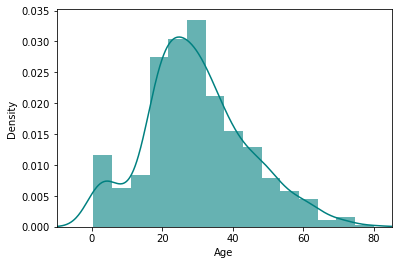

In [ ]:
ax = data['Age'].hist(bins = 15, density = True,  stacked = True,
                          color = 'teal', alpha= 0.6)
data['Age'].plot(kind = 'density', color = 'teal') #density plot 그려줌
ax.set(xlabel = 'Age') #x축에 Age 라벨링
plt.xlim(-10, 85) #축 범위 설정
plt.show() #코랩에서는 따로 실행하지 않아도 plot이 나오긴 함

In [ ]:
data['Age'].fillna(data['Age'].median(skipna = True), inplace = True)

Plot이 skewed to the right이기 때문에 median을 이용하여 결측치를 채워주었습니다.

In [ ]:
data.drop('Cabin', axis = 1, inplace = True)

Cabin의 경우 결측치가 너무 많이 존재하기 때문에 열 자체를 drop 해주었습니다.

S    644
C    168
Q     77
Name: Embarked, dtype: int64


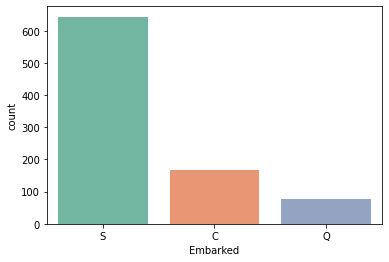

In [ ]:
print(data['Embarked'].value_counts())
sns.countplot(x = 'Embarked', data = data, palette = 'Set2')
plt.show()

In [ ]:
data['Embarked'].fillna(data['Embarked'].value_counts().idxmax(), inplace = True)

Embarked의 경우 최빈값인 S로 결측치를 채워주었습니다.

In [ ]:
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

더 이상 결측치가 존재하지 않습니다.

## Creating new features

같이 배에 탑승한 배우자, 형제의 수를 나타내는 SibSp, 부모, 자녀의 수를 나타내는 Parch를 이용하여 Alone이라는 feature을 새로 생성했습니다.
  

Alone = 0: 가족과 함께 여행 중  
Alone = 1: 혼자 여행 중  

  
Alone feature을 생성 후 SibSp와 Parch는 drop해주었습니다.

In [ ]:
data['Alone'] = np.where(data['SibSp'] + data['Parch'] > 0, 0, 1)
data.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

## Categorical Var -> Numerical Var

In [ ]:
data = pd.get_dummies(data, columns = ['Pclass', 'Embarked', 'Sex'], drop_first = True)
data.head()

,Survived,Age,Fare,Alone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


# 과제

In [ ]:
input = data.drop("Survived", axis = 1)
output = data['Survived']

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= output, shuffle = True)

x_train = torch.FloatTensor(x_train.values).to(device)
# 32-bit floating point
y_train = torch.LongTensor(y_train.values).to(device)
# 64-bit integer (signed)
x_test = torch.FloatTensor(x_test.values)
# 32-bit floating point
y_test = torch.LongTensor(y_test.values)
# 64-bit integer (signed)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [ ]:
print(x_train[0])
print(y_train[0])

#input 8개 (속성이 8개)
#y의 class는 2개 (생존/생존x)

tensor([19.0000, 53.1000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000],
       device='cuda:0')
tensor(0, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
  # class에서 객체가 생성되면 바로 실행되는 함수
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
  # obs 수를 정의하는 함수
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
  # iteration마다 해당 데이터를 돌려주는 함수
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [ ]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
'''
model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          # input feature가 30개니까 30
          nn.Sigmoid(),
          # activation function으로 sigmoid
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)
'''

## Defining ReLU

In [ ]:
def relu(x):
  a = torch.zeros_like(x)
  return torch.max(x, a)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

## Model 1-1 (ReLU + Adam)

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(8,30, bias=True) # input_layer = 8, hidden_layer1 = 398 
    self.bnorm = nn.BatchNorm1d(30)
    self.layer2 = nn.Linear(30, 10, bias = True)
    self.layer3 = nn.Linear(10, 5, bias = True)
    self.layer4 = nn.Linear(5, 2, bias= True)

  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 
   # activation function의 output 혹은 function의 output을 normal하게 만든다
  
  # 가중치 초기화 문제에서 비교적 자유로워짐

  def forward(self,x):
    output = self.layer1(x)
    output = relu(output)
    output = self.bnorm(output)

    output = self.layer2(output)
    output = relu(output)

    output = self.layer3(output)
    output = relu(output)

    output = self.layer4(output)
    output = F.sigmoid(output)

    return output

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
    # if layer is type of nn.Linear
        torch.nn.init.xavier_uniform(layer.weight)
        # xavier initialization
        # U(-sqrt(6 / (n_in + n_out)), sqrt(6 / (n_in + n_out)))
        layer.bias.data.fill_(0.01)

        # xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


Model(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (bnorm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=30, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.7049669027328491
10 0.6321702003479004
20 0.6056885123252869
30 0.5954875349998474
40 0.5750274062156677
50 0.5456474423408508
60 0.5066906213760376
70 0.4920656383037567
80 0.4825959801673889
90 0.47868114709854126


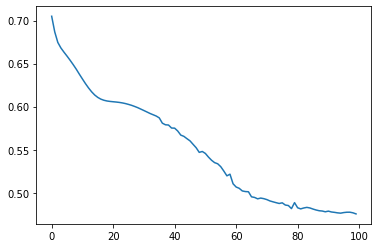

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999237e-01 1.1066741e-04]
argmax를 한 후의 output은 0
accuracy는 0.8059701492537313


## Model 1-2 (ReLU + AdamW) 가장 결과가 좋음

In [ ]:
model = Model().to(device)
model.apply(init_weights)

loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer2 = optim.AdamW(model.parameters(), lr= 0.01)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


In [ ]:
losses = []
for epoch in range(100):

  optimizer2.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer2.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.7370359301567078
10 0.6218928098678589
20 0.5936817526817322
30 0.5868222713470459
40 0.5767459273338318
50 0.5485323667526245
60 0.5096868276596069
70 0.48874935507774353
80 0.47543221712112427
90 0.46623319387435913


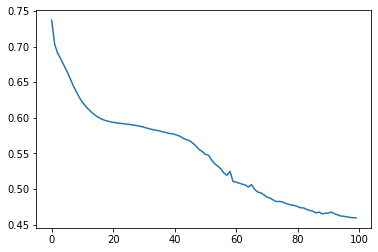

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999607e-01 6.1599884e-08]
argmax를 한 후의 output은 0
accuracy는 0.8171641791044776


Accuracy가 0.12정도 상승했다.

## Model 2-1 (Leaky ReLU + Adam)

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(8,30, bias=True) # input_layer = 8, hidden_layer1 = 398 
    self.bnorm = nn.BatchNorm1d(30)
    self.layer2 = nn.Linear(30, 10, bias = True)
    self.layer3 = nn.Linear(10, 5, bias = True)
    self.layer4 = nn.Linear(5, 2, bias= True)

  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 
   # activation function의 output 혹은 function의 output을 normal하게 만든다
  
  # 가중치 초기화 문제에서 비교적 자유로워짐

  def forward(self,x):
    output = self.layer1(x)
    output = F.leaky_relu(output)
    output = self.bnorm(output)

    output = self.layer2(output)
    output = F.leaky_relu(output)

    output = self.layer3(output)
    output = F.leaky_relu(output)

    output = self.layer4(output)
    output = F.sigmoid(output)

    return output

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
    # if layer is type of nn.Linear
        torch.nn.init.xavier_uniform(layer.weight)
        # xavier initialization
        # U(-sqrt(6 / (n_in + n_out)), sqrt(6 / (n_in + n_out)))
        layer.bias.data.fill_(0.01)

        # xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


Model(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (bnorm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=30, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.713340699672699
10 0.6052659749984741
20 0.5927756428718567
30 0.5805928111076355
40 0.5347403883934021
50 0.5019533634185791
60 0.4851914942264557
70 0.47619521617889404
80 0.4724831283092499
90 0.46939733624458313


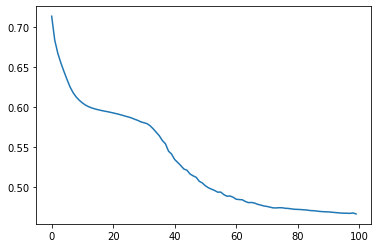

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9917197  0.00230077]
argmax를 한 후의 output은 0
accuracy는 0.8022388059701493


## Model 2-1 (Leaky ReLU + AdamW)

In [ ]:
model = Model().to(device)
model.apply(init_weights)

loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer2 = optim.AdamW(model.parameters(), lr= 0.01)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


In [ ]:
losses = []
for epoch in range(100):

  optimizer2.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer2.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.6753653883934021
10 0.5978167057037354
20 0.5812813639640808
30 0.5452846884727478
40 0.5063865184783936
50 0.48603498935699463
60 0.4768952429294586
70 0.472952663898468
80 0.47318387031555176
90 0.46672412753105164


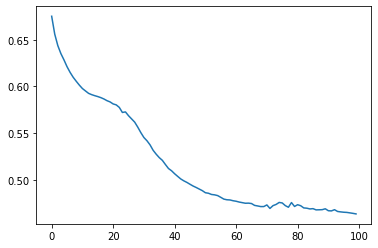

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9959844e-01 1.1403917e-04]
argmax를 한 후의 output은 0
accuracy는 0.8097014925373134


Accuracy가 0.07정도 상승했다.

## Model 3 (ReLU + Dropout + AdamW)

In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(8,30, bias=True) # input_layer = 8, hidden_layer1 = 398 
    self.bnorm = nn.BatchNorm1d(30)
    self.layer2 = nn.Linear(30, 10, bias = True)
    self.layer3 = nn.Linear(10, 5, bias = True)
    self.layer4 = nn.Linear(5, 2, bias= True)
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.5)

  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 
   # activation function의 output 혹은 function의 output을 normal하게 만든다
  
  # 가중치 초기화 문제에서 비교적 자유로워짐

  def forward(self,x):
    output = self.layer1(x)
    output = relu(output)
    output = self.bnorm(output)

    output = self.layer2(output)
    output = relu(output)
    output = self.dropout1(output)

    output = self.layer3(output)
    output = relu(output)
    output = self.dropout2(output)

    output = self.layer4(output)
    output = F.sigmoid(output)

    return output

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
    # if layer is type of nn.Linear
        torch.nn.init.xavier_uniform(layer.weight)
        # xavier initialization
        # U(-sqrt(6 / (n_in + n_out)), sqrt(6 / (n_in + n_out)))
        layer.bias.data.fill_(0.01)

        # xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


Model(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (bnorm): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=30, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=2, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.6951936483383179
10 0.6274287104606628
20 0.6136776208877563
30 0.6160262227058411
40 0.5962832570075989
50 0.5899001359939575
60 0.5649012923240662
70 0.5289332866668701
80 0.523799479007721
90 0.5347988605499268


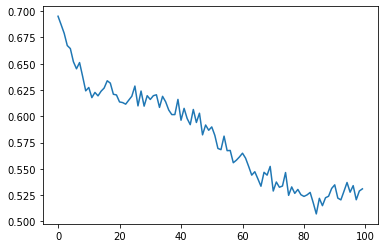

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9965703e-01 1.4007113e-06]
argmax를 한 후의 output은 0
accuracy는 0.7425373134328358


accuracy가 대폭 감소했습니다.